<a href="https://colab.research.google.com/github/biellefernanded/resultados-Meli/blob/main/Meli_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# DESAFIO (2): Os armazéns no mercado livre possuem uma frota de máquinas que transmitem diariamente medidas sobre seu status e funcionamento.
# As técnicas de manutenção preditiva são projetadas para ajudar a determinar a condição do equipamento de manutenção em serviço para prever quando a manutenção
# deve ser realizada. Esta abordagem promete economia de custos em relação à manutenção preventiva de rotina ou baseada no tempo, porque as tarefas são
# executadas apenas quando justificada, em média uma interrupção por falha custa o dobro de uma interrupção preventiva.
# O arquivo "full_devices.csv" possui os valores diários de 9 atributos dos dispositivos ao longo do tempo e a coluna que você está tentando prever é chamada
# de 'failure' com o valor binário 0 para nenhuma falha e 1 para falha, a coluna do dispositivo possui o id do dispositivo.

# O objetivo do desafio: gerar um modelo para prever a probabilidade de falha do dispositivo antes de uma possível falha.
# Tentar calcular a possível economia gerada pelo modelo.


In [6]:
#1.Importando as bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)


In [15]:
#2.Carregamento da base de dados

df = pd.read_csv("full_devices.csv", encoding='latin1')

# Conferências simples
assert "failure" in df.columns, "Falta a coluna 'failure' (0/1)."
assert "device" in df.columns, "Falta a coluna 'device' (ID)."

# Garantir binário 0/1
df["failure"] = (df["failure"] == 1).astype(int)
print("Formato:", df.shape, "| Taxa de falha (%):", round(df["failure"].mean()*100, 2))

Formato: (124494, 12) | Taxa de falha (%): 0.09


In [16]:
#3. Informacoes gerais e estatisticas

# Verificando os tipos das variaveis, valores faltantes e contagem
df.info()

# Estatísticas descritivas (numéricas e categóricas)
df.describe(include="all", percentiles=[.25,.5,.75]).T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,124494,304,2015-01-01,1163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
device,124494,1169,S1F0E9EP,304,NaN,NaN,NaN,NaN,NaN,NaN,NaN
failure,124494.0,NaN,NaN,NaN,0.000851,0.029167,0.0,0.0,0.0,0.0,1.0
attribute1,124494.0,NaN,NaN,NaN,122388103.242124,70459334.21636,0.0,61284762.0,122797388.0,183309640.0,244140480.0
attribute2,124494.0,NaN,NaN,NaN,159.484762,2179.65773,0.0,0.0,0.0,0.0,64968.0
attribute3,124494.0,NaN,NaN,NaN,9.940455,185.747321,0.0,0.0,0.0,0.0,24929.0
attribute4,124494.0,NaN,NaN,NaN,1.74112,22.908507,0.0,0.0,0.0,0.0,1666.0
attribute5,124494.0,NaN,NaN,NaN,14.222669,15.943028,1.0,8.0,10.0,12.0,98.0
attribute6,124494.0,NaN,NaN,NaN,260172.657726,99151.078547,8.0,221452.0,249799.5,310266.0,689161.0
attribute7,124494.0,NaN,NaN,NaN,0.292528,7.436924,0.0,0.0,0.0,0.0,832.0


In [17]:
#4. SELEÇÃO DE FEATURES SIMPLES
# (apenas numéricas, sem lags/rolagens)

# Evitar usar colunas de data/tempo como preditoras
date_like = [c for c in df.columns if any(k in c.lower() for k in ["date","dt","time","timestamp"])]
# Pegar só colunas numéricas
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
# Remover target, id e datas
drop_cols = ["failure", "device"] + date_like
X_cols = [c for c in num_cols if c not in drop_cols]

X = df[X_cols].copy()
y = df["failure"].astype(int)
print("Nº de features usadas:", len(X_cols))


Nº de features usadas: 9


In [18]:
# 5. TREINO/TESTE

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [19]:
# 6. Definindo 3 modelos
#  (imputação por mediana; scaler só para Regressão Logística)

pipe_lr = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])

pipe_gb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=42))
])

modelos = {
    "LogisticRegression": pipe_lr,
    "RandomForest": pipe_rf,
    "GradientBoosting": pipe_gb
}

# Treinar os três
for nome, mdl in modelos.items():
    mdl.fit(X_train, y_train)


In [20]:
# 7. AVALIAR (ROC-AUC e PR-AUC) + MATRIZ (limiar=0.5)

resultados = []

for nome, mdl in modelos.items():
    # Probabilidade de falha no TESTE
    proba = mdl.predict_proba(X_test)[:, 1]

    # Métricas principais
    roc = roc_auc_score(y_test, proba)
    pr  = average_precision_score(y_test, proba)  # PR-AUC (boa p/ classe rara)

    # Classe prevista com limiar 0.5
    pred = (proba >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall    = tp / (tp + fn) if (tp + fn) else 0.0

    resultados.append({
        "modelo": nome,
        "roc_auc": roc,
        "pr_auc": pr,
        "precision@0.5": precision,
        "recall@0.5": recall,
        "tp": tp, "fp": fp, "fn": fn, "tn": tn,
        "proba": proba  # guardamos para plotar curvas depois
    })

# Mostrar tabela resumida (ordenada por PR-AUC)
resumo = pd.DataFrame([{k:v for k,v in r.items() if k!="proba"} for r in resultados]) \
           .sort_values("pr_auc", ascending=False)
print("\nResumo (ordenado por PR-AUC):")
display(resumo.round(4))



Resumo (ordenado por PR-AUC):


,modelo,roc_auc,pr_auc,precision@0.5,recall@0.5,tp,fp,fn,tn
0,LogisticRegression,0.7196,0.0663,0.0,0.0,0,0,21,24878
2,GradientBoosting,0.7855,0.0359,0.0,0.0,0,2,21,24876
1,RandomForest,0.7051,0.0236,0.0,0.0,0,3,21,24875


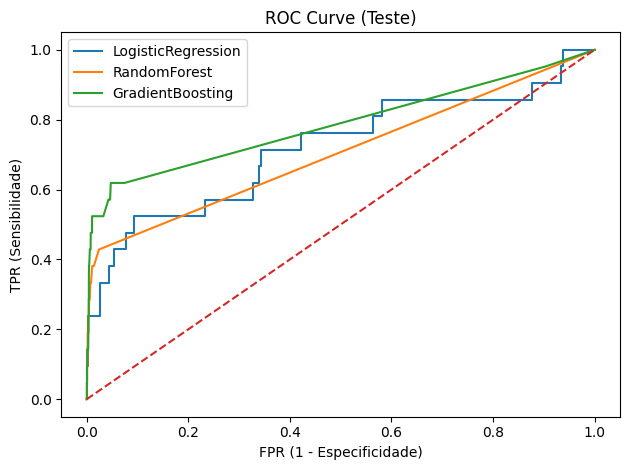

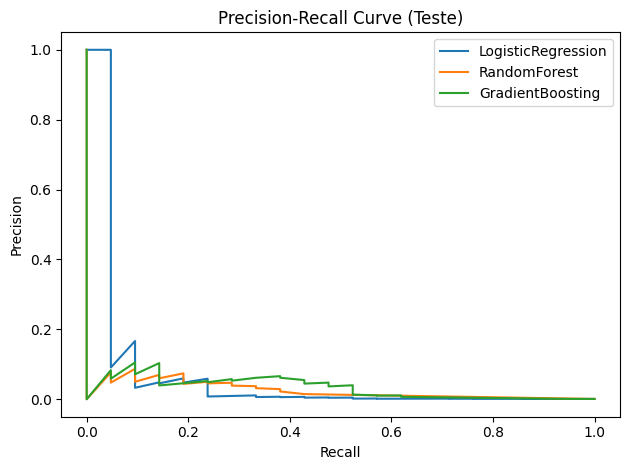

In [21]:
# 8. CURVAS (ROC e PR) — OPCIONAL

plt.figure()
for r in resultados:
    fpr, tpr, _ = roc_curve(y_test, r["proba"])
    plt.plot(fpr, tpr, label=r["modelo"])
plt.plot([0,1],[0,1],"--")
plt.title("ROC Curve (Teste)")
plt.xlabel("FPR (1 - Especificidade)")
plt.ylabel("TPR (Sensibilidade)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for r in resultados:
    prec, rec, _ = precision_recall_curve(y_test, r["proba"])
    plt.plot(rec, prec, label=r["modelo"])
plt.title("Precision-Recall Curve (Teste)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# 9. ECONOMIA (SIMPLES) COM O MELHOR POR PR-AUC
# Premissa: C_fail = 2 * C_prev (falha custa o dobro da preventiva)

C_prev = 1.0
C_fail = 2.0 * C_prev

# Escolher o melhor por PR-AUC (mais apropriado em desequilíbrio)
best = max(resultados, key=lambda x: x["pr_auc"])
best_name = best["modelo"]
best_proba = best["proba"]
print("\nMelhor modelo por PR-AUC:", best_name)

# Economia comparando política reativa (não faz nada) vs. política do modelo
# Política reativa: custo = (#falhas) * C_fail
base_cost = y_test.sum() * C_fail

# Procurar limiar que dá maior economia (varremos alguns valores simples)
thresholds = np.linspace(0.05, 0.95, 19)
melhor = None

for thr in thresholds:
    pred_prev = (best_proba >= thr).astype(int)            # 1 = faz preventiva
    num_prev  = pred_prev.sum()
    missed    = ((pred_prev == 0) & (y_test == 1)).sum()   # falhas não prevenidas

    policy_cost = num_prev * C_prev + missed * C_fail
    savings = base_cost - policy_cost

    item = {"thr": float(thr), "savings": float(savings),
            "preventivas": int(num_prev), "falhas_nao_prevenidas": int(missed)}
    if (melhor is None) or (savings > melhor["savings"]):
        melhor = item

print("Limiar com maior economia:", round(melhor["thr"], 3))
print("Economia estimada:", round(melhor["savings"], 2), "(em unidades de C_prev)")
print("Preventivas:", melhor["preventivas"], "| Falhas não prevenidas:", melhor["falhas_nao_prevenidas"])



Melhor modelo por PR-AUC: LogisticRegression
Limiar com maior economia: 0.2
Economia estimada: 1.0 (em unidades de C_prev)
Preventivas: 1 | Falhas não prevenidas: 20


In [23]:
# ========================================================#
# CONCLUSÃO:                                              #
# ========================================================#

print("\n=== Conclusão ===")
print(f"- Melhor modelo (PR-AUC): {best_name}")
print(f"- Limiar sugerido por economia: {melhor['thr']:.3f}")
print(f"- Economia estimada vs. reativo: {melhor['savings']:.2f} (em C_prev)")
print("- Use este limiar como ponto de partida e ajuste C_prev/C_fail conforme sua operação.")



=== Conclusão ===
- Melhor modelo (PR-AUC): LogisticRegression
- Limiar sugerido por economia: 0.200
- Economia estimada vs. reativo: 1.00 (em C_prev)
- Use este limiar como ponto de partida e ajuste C_prev/C_fail conforme sua operação.
